In [19]:
import logging
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rxr
import xarray as xr
import pandas as pd
from affine import Affine
from geopandas.geodataframe import GeoDataFrame
from rasterio.features import rasterize
from sklearn.ensemble import RandomForestClassifier

from training_raster_clipper.core.logging import log_info
from training_raster_clipper.core.models import TrainingConfiguration, TrainingFunctions
from training_raster_clipper.core.visualization import (
    plot_array,
    plot_geodataframe,
    plot_rgb_data_array,
)
from training_raster_clipper.custom_types import (
    BandNameType,
    ClassificationResult,
    ClassifiedSamples,
    FeatureClassNameToId,
    PolygonMask,
    ResolutionType,
)

import logging

In [2]:
# See https://stackoverflow.com/questions/18786912/get-output-from-the-logging-module-in-ipython-notebook
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.info("test") 

INFO:root:test


In [47]:
raster_input_path = Path(
    "D:/Trainings/HW/Data/"
)
polygons_input_path = Path(
    "D:/Trainings/HW/Ploygon/Polygons.geojson"
)

assert raster_input_path.exists() and raster_input_path.is_dir()
assert polygons_input_path.exists() and polygons_input_path.is_file()

output_path = Path('D:/Trainings/HW/generated/')

if not (output_path.exists() and output_path.is_dir()):
    output_path.mkdir()

config = TrainingConfiguration(
    verbose=True,
    show_plots=True,
    resolution=60,
    band_names=("B04", "B03", "B02", "B8A"),
    raster_input_path=raster_input_path,
    polygons_input_path=polygons_input_path,
    csv_output_path = (output_path.resolve() / Path("classified_points.csv")),
    raster_output_path=(output_path.resolve() / Path("sklearn_raster.tiff")),
    implementation_name="eschalk",
)
config


TrainingConfiguration(verbose=True, show_plots=True, resolution=60, band_names=('B04', 'B03', 'B02', 'B8A'), raster_input_path=WindowsPath('D:/Trainings/HW/Data'), polygons_input_path=WindowsPath('D:/Trainings/HW/Ploygon/Polygons.geojson'), csv_output_path=WindowsPath('D:/Trainings/HW/generated/classified_points.csv'), raster_output_path=WindowsPath('D:/Trainings/HW/generated/sklearn_raster.tiff'), implementation_name='eschalk')

In [48]:
verbose = config.verbose
show_plots = config.show_plots

resolution = config.resolution
band_names = config.band_names

raster_input_path = config.raster_input_path
polygons_input_path = config.polygons_input_path
csv_output_path = config.csv_output_path
raster_output_path = config.raster_output_path


### (1) Load a GeoJSON file with `geopandas`

In [49]:
def load_feature_polygons(input_path: Path) -> GeoDataFrame:
    #Loading the Polygons
    poly_file = gpd.read_file(input_path)
    #Converting the coordinate system from EPSG 4326 format, to the Sentinel-2 raster: 32631
    poly_file = poly_file.to_crs(32631)

    return poly_file
    


INFO:root:polygons:
    id     class  color                                           geometry
0    0     water   blue  MULTIPOLYGON (((342464.690 4883783.637, 342627...
1    0     water   blue  MULTIPOLYGON (((343702.859 4882680.457, 343935...
2    0     water   blue  MULTIPOLYGON (((339855.693 4883539.262, 339087...
3    0     water   blue  MULTIPOLYGON (((344086.877 4881267.735, 344263...
4    1    forest  green  MULTIPOLYGON (((359978.258 4870035.777, 359838...
5    1    forest  green  MULTIPOLYGON (((356077.562 4875346.869, 356529...
6    0     water   blue  MULTIPOLYGON (((344461.586 4880541.591, 344310...
7    1    forest  green  MULTIPOLYGON (((351706.734 4829415.937, 354369...
8    1    forest  green  MULTIPOLYGON (((356398.741 4836584.281, 359806...
9    1    forest  green  MULTIPOLYGON (((354704.405 4832711.513, 354350...
10   1    forest  green  MULTIPOLYGON (((358167.553 4835913.994, 359415...
11   1    forest  green  MULTIPOLYGON (((342937.150 4847020.273, 344342...
12   

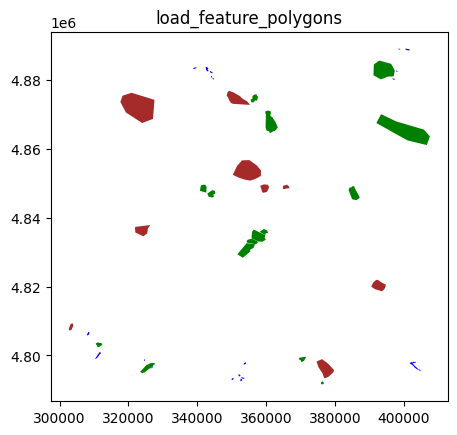

In [50]:
polygons = load_feature_polygons(polygons_input_path)
if verbose:
    log_info(polygons, "polygons")
if show_plots:
    plot_geodataframe(polygons, f"{load_feature_polygons.__name__}")


### (2) Load a Sentinel-2 raster with `rioxarray`

In [51]:
def load_sentinel_data(
    sentinel_product_location: Path,
    resolution: ResolutionType,
    band_names: tuple[BandNameType, ...],
) -> xr.DataArray:
    """Loads sentinel product

    Example input path: `S2A_MSIL2A_20221116T105321_N0400_R051_T31TCJ_20221116T170958.SAFE`

    Args:
        sentinel_product_location (Path): Location of the .SAFE folder containing a Sentinel-2 product.

    Returns:
        xr.DataArray: A DataArray containing the 3 RGB bands from the visible spectrum
    """

    # Read each band into an xarray DataArray and store in a dictionary, using dictionary comprehension
    band_data = {
        band: rxr.open_rasterio(next(sentinel_product_location.glob(f"*{band}*")), masked=True).squeeze()
        for band in band_names}
    
    #The .squeeze() is used to remove dimensions of size 1 from an xarray DataArray or Dataset. 
    #When you read a single-band raster file using rioxarray or rasterio, it usually comes in with dimensions like (1, height, width).
    #The masked=True argument is used when opening the raster file with rioxarray to automatically convert any NoData values in the raster to NaN (Not a Number) in the resulting xarray DataArray.
    #rioxarray and rasterio can automatically detect NoData values based on the raster file's metadata. 
    
    # Concatenate the individual bands into a single xarray DataArray along a new 'band' dimension
    all_bands = xr.concat(list(band_data.values()), dim='band')
    all_bands['band'] = list(band_data.keys())  # Assign band names to the 'band' coordinate

    # Convert the data type to np.float32
    all_bands = all_bands.astype(np.float32)

    #Pre-processing on rasters
    offset = -1000.0
    quantification = 10000.0
    #Normalization
    all_bands = (all_bands + offset) / quantification

    
    return all_bands


INFO:root:rasters:
<xarray.DataArray (band: 4, y: 1830, x: 1830)>
array([[[0.072 , 0.0677, 0.0614, ..., 0.0329, 0.0313, 0.0291],
        [0.071 , 0.0666, 0.0674, ..., 0.0315, 0.0296, 0.0329],
        [0.0797, 0.0531, 0.0551, ..., 0.0305, 0.0296, 0.0344],
        ...,
        [0.0353, 0.0321, 0.0216, ..., 0.0713, 0.0412, 0.0603],
        [0.016 , 0.0325, 0.0314, ..., 0.1727, 0.163 , 0.108 ],
        [0.0248, 0.0357, 0.0402, ..., 0.1427, 0.133 , 0.148 ]],

       [[0.0611, 0.0578, 0.05  , ..., 0.0461, 0.0437, 0.0419],
        [0.0606, 0.0509, 0.048 , ..., 0.044 , 0.0402, 0.044 ],
        [0.0603, 0.0463, 0.0462, ..., 0.0426, 0.042 , 0.0465],
        ...,
        [0.039 , 0.043 , 0.0325, ..., 0.0606, 0.0412, 0.0514],
        [0.0243, 0.0442, 0.0474, ..., 0.1279, 0.1241, 0.0886],
        [0.0347, 0.0467, 0.0508, ..., 0.1062, 0.0989, 0.1136]],

       [[0.0347, 0.0323, 0.0276, ..., 0.0134, 0.0132, 0.0132],
        [0.0341, 0.0304, 0.0288, ..., 0.0135, 0.0129, 0.0146],
        [0.0349, 0.023

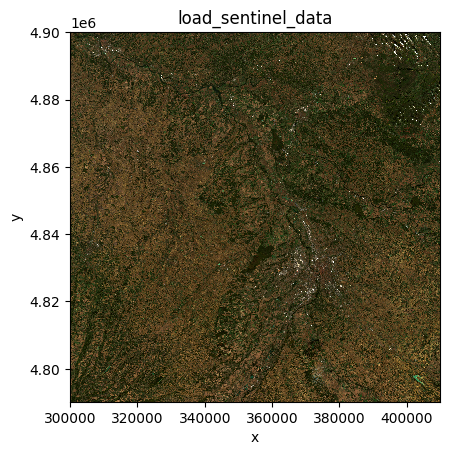

In [52]:
rasters = load_sentinel_data(raster_input_path, resolution, band_names)
if verbose:
    log_info(rasters, "rasters")
if show_plots:
    plot_rgb_data_array(rasters, f"{load_sentinel_data.__name__}")


### (3) Rasterize the polygons

In [53]:
def rasterize_geojson(
    data_array: xr.DataArray,
    training_classes: GeoDataFrame,
) -> tuple[PolygonMask, FeatureClassNameToId]:
    """Burns a set of vectorial polygons to a raster.

    See https://gis.stackexchange.com/questions/316626/rasterio-features-rasterize

    Args:
        data_array (xr.DataArray): The Sentinel raster, from which data is taken, such as the transform or the shape.
        training_classes (GeoDataFrame): The input set of classified multipolygons to burn

    Returns:
        xr.DataArray: A mask raster generated from the polygons, representing the same geographical region as the source dataarray param
                      0 where no polygon were found, and integers representing classes in order of occurence in the GeoDataFrame
    """

    #extracting the shape from the raster
    raster_shape = data_array.isel(band = 0).shape

    #the transform 
    transfrom = rasters.spatial_ref.GeoTransform
    #the output shows a string displaying a GDAL-style geotransform parameters (six parameters):
    # -a: top left x coordinate (longitude) 
    # -b: width of a pixel in x direction
    # -c: rotation (typically 0)
    # -d: top left y coordinate (latitude)
    # -e: rotation (typically 0)
    # -f: height of a pixel (in y direction, usually negative)

    #getting the different paramaters and convert them to floats instead of strings
    transfrom = [float(a) for a in transfrom.split()]

    #Converting the transform to the required format (Affine) by feature.rasterize
    transfrom = Affine.from_gdal(*transfrom)


    #getting the Polygons geometry 
    geom = [(g, v) for g, v in zip(training_classes.geometry, training_classes.id.values+1)]

    #getting the classes
    unique_classes = dict(zip(training_classes['class'].values, training_classes.id.values + 1))
    cls = {cl: val for cl, val in unique_classes.items()}


    #mask building: resizing and geomtery encoding. Ensuring the mask will have the correct designated type (PolygonMask) 
    mask: PolygonMask = rasterize(geom, out_shape = raster_shape, transform = transfrom, all_touched = False, dtype=np.uint8)

    return [mask, cls]


INFO:root:burnt_polygons:
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
INFO:root:mapping:
{'farmland': 3, 'forest': 2, 'water': 1}


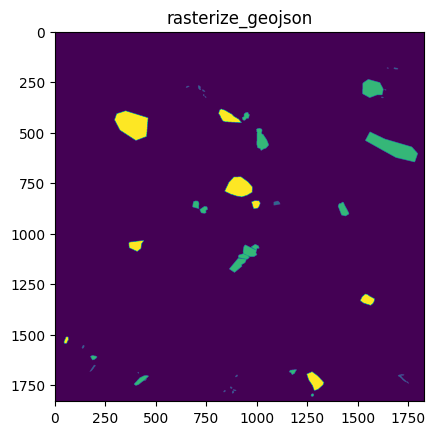

In [54]:
burnt_polygons, mapping = rasterize_geojson(rasters, polygons)
if verbose:
    log_info(burnt_polygons, "burnt_polygons")
    log_info(mapping, "mapping")
if show_plots:
    plot_array(burnt_polygons, f"{rasterize_geojson.__name__}")


### (4) Intersect the Sentinel-2 raster with polygons

In [55]:
def produce_clips(
    data_array: xr.DataArray, burnt_polygons: PolygonMask, mapping: FeatureClassNameToId
) -> ClassifiedSamples:
    """Extract RGB values covered by classified polygons

    Args:
        data_array (xr.DataArray): RGB raster
        burnt_polygons (PolygonMask): Rasterized classified multipolygons

    Returns:
        _type_: A list of the RGB values contained in the data_array and their corresponding classes
    """
    #to host a new xarray.Dataset containing the reflectance and the features ID
    ref_feature = None
    #getting the features IDs from the mapping dictionary
    for _, id_feature in mapping.items():
        #flatten the rasters reflectance and assign it to new dimension variable z
        ref = data_array.stack(z = ('x', 'y'))
        #flatten the mask
        poly = burnt_polygons.flatten()
        #using the mask to select the reflectance pixels under the current feature in the loop (water, forest, or farmland)
        ref = ref.isel(z = poly == id_feature)
        #removing un-needed variables
        ref = ref.drop_vars(('y', 'x', 'spatial_ref')) 

        #putting the id feature into an xr.Dataset similar the selected reflectance
        feature_arr = xr.ones_like(ref.z) * id_feature

        #combine the reflectance data, if the xr.Dataset exist or generate a one if not
        if ref_feature:
            ref_feature = xr.concat([ref_feature, xr.Dataset({'reflectance': ref,'feature_id': feature_arr})], dim= 'z')
        else:
            ref_feature = xr.Dataset({'reflectance': ref,'feature_id': feature_arr})

    return ref_feature


In [56]:
classified_rgb_rows = produce_clips(rasters, burnt_polygons, mapping)
if verbose:
    log_info(classified_rgb_rows, "classified_rgb_rows")


INFO:root:classified_rgb_rows:
<xarray.Dataset>
Dimensions:      (band: 4, z: 84655)
Coordinates:
  * band         (band) <U3 'B04' 'B03' 'B02' 'B8A'
Dimensions without coordinates: z
Data variables:
    reflectance  (band, z) float32 0.0353 0.0322 0.0295 ... 0.1239 0.1311 0.1971
    feature_id   (z) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 3 3 3 3 3 3 3 3 3 3 3 3


### (5) Persist the intersection to a CSV

In [58]:
def persist_to_csv(
    classified_rgb_rows: ClassifiedSamples,
    csv_output_path: Path,
) -> None:

    #converting the reflectance DataArray into pandas.DataFrame after transposing the DataArray so we have four columns corresponding to the four bands
    pd_df = classified_rgb_rows.reflectance.T.to_pandas()
    #adding the features IDs to the DataFrame
    pd_df['feature_id'] = classified_rgb_rows.feature_id.data

    #saveing the DataFrame as CSV file with separator ';'
    pd_df.to_csv(csv_output_path, sep = ';', index = False)



In [59]:
persist_to_csv(classified_rgb_rows, csv_output_path)
log_info(f"Written CSV output {csv_output_path}")


INFO:root:Written CSV output D:\Trainings\HW\generated\classified_points.csv


### (6) Train a machine learning model

In [96]:
def classify_sentinel_data(
    rasters: xr.DataArray, classified_rgb_rows: ClassifiedSamples
) -> ClassificationResult:
    
    #getting the features reflectance and the labels, the current shape of the reflectance array is 4xn (row: bands, col: ref), so we transpose it to get nx4 (row: ref, col: bands)
    feature_ref = classified_rgb_rows.reflectance.T
    feature_label = classified_rgb_rows.feature_id

    #initiating the classifier, n_job is to speed the process through parallelization
    classifier = RandomForestClassifier(n_jobs = 4)#n_estimators=100, random_state=42)

    #training the model in the features reflectance and the labels
    classifier.fit(feature_ref, feature_label)

    #preparing the rasters for prediction by flattening the reflectance data assign it to new dimension variable z and transpose it to match the train data
    flt_data = rasters.stack(z = ('x', 'y')).T

    #predicting the classes of the rasters
    prd_classes = classifier.predict(flt_data)

    #reshaping the prediction result to match the original shape and put it into [through .copy(data=)] xr.DataArry with the same metadata and attribute as the rasters
    xr_holder = rasters.isel(band = 0, drop=True)
    classifier_output = xr_holder.copy(data=prd_classes.reshape(xr_holder.shape)) 
    #ensuring the same data type as the original raster 
    classifier_output = classifier_output.astype(np.float32) 

    return classifier_output

#a function to read the classification CSV file provided in the solution to test the model and check the impact of the Polygons mask 
#used to extract the classes reflectance
def classify_sentinel_data_sol(
    rasters: xr.DataArray, classified_rgb_rows_sol: Path
) -> ClassificationResult:
    
    #loading the classified rgb reflectenace
    df_classified_ref = pd.read_csv(classified_rgb_rows_sol, sep = ';')
    
    #getting the features reflectance and the labels 
    feature_ref = df_classified_ref[['B04','B03','B02','B8A']].values
    feature_label = df_classified_ref.feature_id.values

    #initiating the classifier, n_job is to speed the process through parallelization
    classifier = RandomForestClassifier(n_jobs = 4)#n_estimators=100, random_state=42)

    #training the model in the features reflectance and the labels
    classifier.fit(feature_ref, feature_label)

    #preparing the rasters for prediction by flattening the reflectance data assign it to new dimension variable z and transpose it to match the train data
    flt_data = rasters.stack(z = ('x', 'y')).T

    #predicting the classes of the rasters
    prd_classes = classifier.predict(flt_data)

    #reshaping the prediction result to match the original shape and put it into [through .copy(data=)] xr.DataArry with the same metadata and attribute as the rasters
    xr_holder = rasters.isel(band = 0, drop=True)
    classifier_output = xr_holder.copy(data=prd_classes.reshape(xr_holder.shape))
    #ensuring the same data type as the original raster 
    classifier_output = classifier_output.astype(np.float32) 

    return classifier_output





INFO:root:classification_result:
<xarray.DataArray (y: 1830, x: 1830)>
array([[3, 3, 3, ..., 2, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [2, 3, 3, ..., 3, 2, 2],
       ...,
       [3, 3, 3, ..., 2, 3, 2],
       [2, 3, 3, ..., 2, 3, 2],
       [3, 3, 3, ..., 2, 3, 3]], dtype=int64)
Coordinates:
  * x            (x) float64 3e+05 3.001e+05 3.002e+05 ... 4.097e+05 4.098e+05
  * y            (y) float64 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
    spatial_ref  int32 0


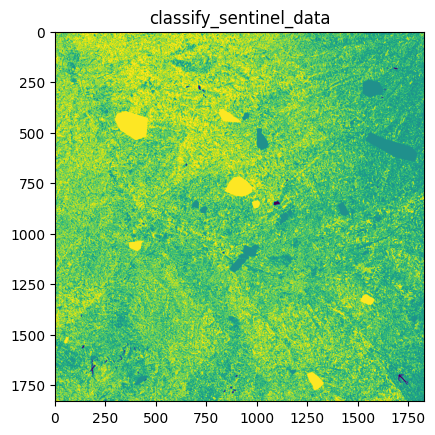

In [97]:
classification_result = classify_sentinel_data(rasters, classified_rgb_rows)

#classify_sentinel_data_sol_path = Path("D:/Trainings/HW/generated/classified_points_sol_to_read.csv")
#classification_result = classify_sentinel_data_sol(rasters, classify_sentinel_data_sol_path)

if verbose:
    log_info(classification_result, "classification_result")
if show_plots:
    plot_array(
        classification_result, f"{classify_sentinel_data.__name__}"
    )


### (7) Export the classification raster result

In [89]:
def persist_classification_to_raster(
    raster_output_path: Path, classification_result: ClassificationResult
) -> None:
    
    #retrieving the crs_wkt attribute from the spatial_ref dimension (probably unnecessary step as the classification_result is a xr.DataArry with the same metadata and attributes as the raster)
    crs_wkt = classification_result.spatial_ref.crs_wkt
    #setting the CRS based on the crs_wkt attribute of the spatial_ref dim of the original sentinel raster
    classification_result.rio.write_crs(crs_wkt, inplace=True)
    #storing the resulted raster of the classification 
    classification_result.rio.to_raster(raster_output_path)


In [98]:
classification_result

<xarray.DataArray (y: 1830, x: 1830)>
array([[3, 3, 3, ..., 2, 3, 3],
       [3, 3, 3, ..., 3, 3, 3],
       [2, 3, 3, ..., 3, 2, 2],
       ...,
       [3, 3, 3, ..., 2, 3, 2],
       [2, 3, 3, ..., 2, 3, 2],
       [3, 3, 3, ..., 2, 3, 3]], dtype=int64)
Coordinates:
  * x            (x) float64 3e+05 3.001e+05 3.002e+05 ... 4.097e+05 4.098e+05
  * y            (y) float64 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
    spatial_ref  int32 0

In [88]:
t = rxr.open_rasterio(Path("D:/Trainings/HW/Data/T31TCJ_20221116T105321_B02_60m.jp2"), masked=True).squeeze()
t

<xarray.DataArray (y: 1830, x: 1830)>
[3348900 values with dtype=float32]
Coordinates:
    band         int32 1
  * x            (x) float64 3e+05 3.001e+05 3.002e+05 ... 4.097e+05 4.098e+05
  * y            (y) float64 4.9e+06 4.9e+06 4.9e+06 ... 4.79e+06 4.79e+06
    spatial_ref  int32 0
Attributes:
    scale_factor:  1.0
    add_offset:    0.0

In [77]:
persist_classification_to_raster(
    raster_output_path, classification_result
)
log_info(f"Written Classified Raster to {raster_output_path}")

# --

log_info("Congratulations, you reached the end of the tutorial!")


INFO:root:Written Classified Raster to D:\Trainings\HW\generated\sklearn_raster.tiff
INFO:root:Congratulations, you reached the end of the tutorial!
